In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
import scipy

In [2]:
df = pd.read_csv('acredit_card_default_analysis.csv', sep=',')
df = df.set_index('ID')
print(df.shape)
df.head()

(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Task 1

In [62]:
not_returned = df[df['default'] == 1]['LIMIT_BAL']
returned = df[df['default'] == 0]['LIMIT_BAL']
print(not_returned.shape[0], returned.shape[0])

6636 23364


Text(0.5, 1.0, 'Вернули кредит. Медиана: 150000.0')

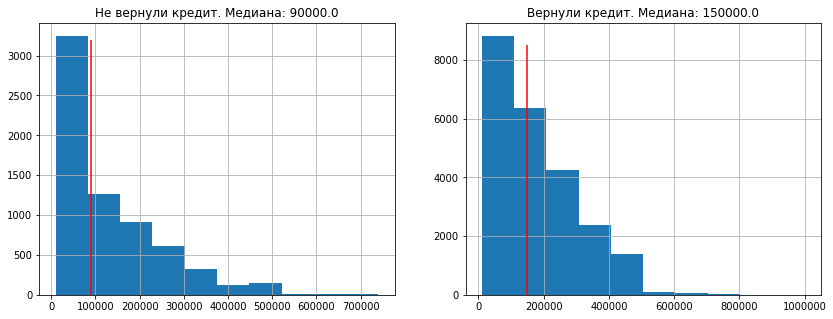

In [63]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
not_returned.hist()
plt.vlines(not_returned.median(), ymin=0, ymax=3200, color='r')
plt.title('Не вернули кредит. Медиана: {}'.format(not_returned.median()))
plt.subplot(1, 2, 2)
returned.hist()
plt.vlines(returned.median(), ymin=0, ymax=8500, color='r')
plt.title('Вернули кредит. Медиана: {}'.format(returned.median()))

### (a) Равенство медиан используя bootstrap

In [11]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.5):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [65]:
not_returned_median_scores = list(map(np.median, get_bootstrap_samples(not_returned.values, 1000)))
returned_median_scores = list(map(np.median, get_bootstrap_samples(returned.values, 1000)))

print("95% confidence interval for NOT returned loans:",  stat_intervals(not_returned_median_scores))
print("95% confidence interval for for returned loans:",  stat_intervals(returned_median_scores))

95% confidence interval for NOT returned loans: [90000. 90000.]
95% confidence interval for for returned loans: [150000. 150000.]


### (b) Ранговый критерий Манна-Уитни
$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [67]:
print('P-value =', stats.mannwhitneyu(not_returned, returned).pvalue)

P-value = 6.127742909111652e-190


### Выводы:<br>

Учитывая доверительный интервал и p-value можно уверенно отвергнуть гипотезу что размер кредитного лимита не влияет на возврат кредита

# Task 2

In [48]:
male = df[df['SEX'] == 1]['default']
female = df[df['SEX'] == 2]['default']

Text(0.5, 1.0, 'Вернули кредит')

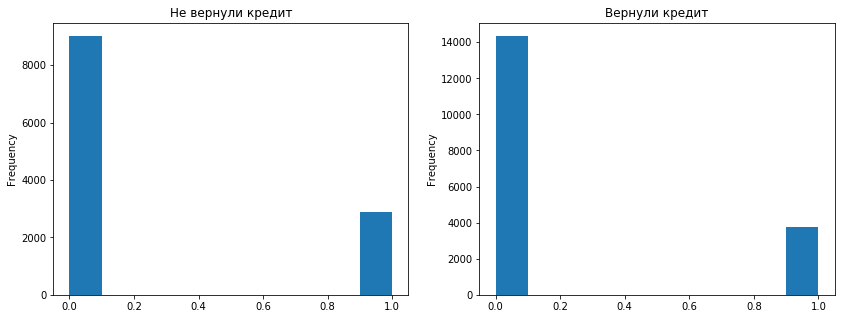

In [49]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
male.plot(kind='hist')
plt.title('Не вернули кредит')

plt.subplot(1, 2, 2)
female.plot(kind='hist')
plt.title('Вернули кредит')

In [43]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [58]:
print('95%% доверительный интервал для разности долей: [%f, %f]' % proportions_diff_confint_ind(male, female))

95% доверительный интервал для разности долей: [0.024207, 0.043612]


### Z-критерий для доли для двух независимых выборок
H0 : p1 = p2<br>
H1 : p1 ≮=> p2

In [42]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1, n2 = sample1.shape[0], sample2.shape[0]
    
    p1 = float(sample1.sum()) / n1
    p2 = float(sample2.sum()) / n2

    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [56]:
print('p-value =', proportions_diff_z_test(proportions_diff_z_stat_ind(male, female)))

p-value = 4.472866521609831e-12


### Выводы:<br>

Учитывая, что доверительный интервал разности долей не пересекает 0 можно сказать что пол влияет на просроченность кредита. Что и подтверждает Z-критерий, уровень значимости которого значительно меньше 0.05.

# Task 3

In [149]:
not_returned_education = df[df['default'] == 1]['EDUCATION']
returned_education = df[df['default'] == 0]['EDUCATION']

nr_education_counts = not_returned_education.value_counts().sort_index()
r_education_counts = returned_education.value_counts().sort_index()

Text(0.5, 1.0, 'Вернули кредит')

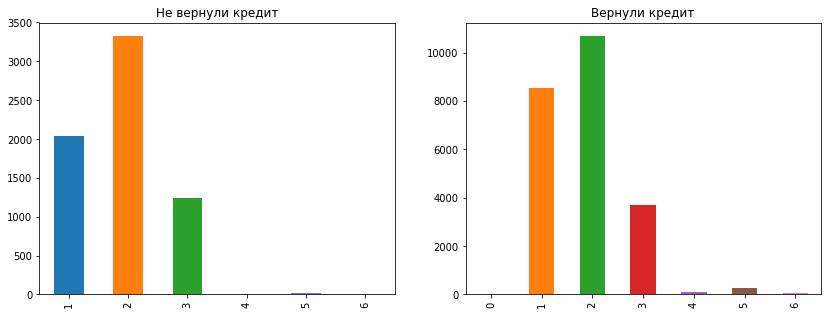

In [150]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
nr_education_counts.plot('bar')
plt.title('Не вернули кредит')

plt.subplot(1, 2, 2)
r_education_counts.plot('bar')
plt.title('Вернули кредит')

In [196]:
def get_observed_and_expected_freq(data):
    mean = np.mean(data)
    observed = np.bincount(data)
    expected = [len(data)*stats.poisson.pmf(x, mean) for x in range(min(data), max(data) + 1)]
    if len(expected) < len(observed):
        expected = [0] + expected
    return observed, expected

In [198]:
observed_frequences_nr, expected_frequences_nr = get_observed_and_expected_freq(not_returned_education.values)

In [199]:
observed_frequences_r, expected_frequences_r = get_observed_and_expected_freq(returned_education)

In [200]:
education_df = pd.DataFrame([expected_frequences_nr - observed_frequences_nr,
                             expected_frequences_r - observed_frequences_r],
                            index=['diff_not_returned', 'diff_returned'])
education_df

,0,1,2,3,4,5,6
diff_not_returned,0.000000,-145.415205,-1538.987144,-105.876600,528.775109,185.022919,56.110085
diff_returned,3691.652203,-1725.645120,-4417.951757,175.789497,1658.952063,391.657017,157.600486


### Вывод:<br>

Судя по таблице, люди, имеющие степень доктора, вероятнее всего отдадут кредит. Люди же, имеющие степень бакалавра скорее всего просрочат выплаты.

# Task 4

In [51]:
marriage_nr = df[df['default'] == 0]['MARRIAGE']
marriage_r = df[df['default'] == 1]['MARRIAGE']

Text(0.5, 1.0, 'Вернули кредит')

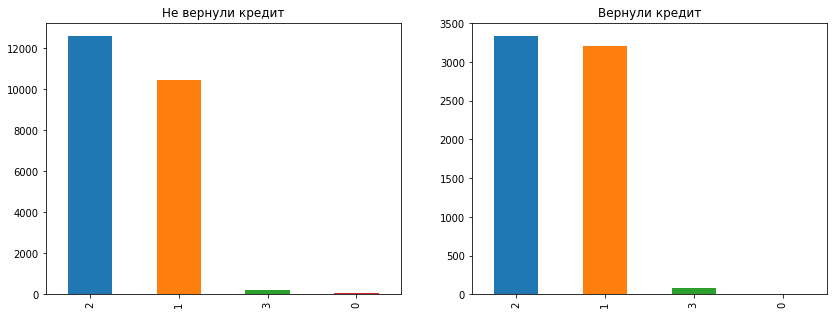

In [5]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
marriage_nr.value_counts().plot('bar')
plt.title('Не вернули кредит')

plt.subplot(1, 2, 2)
marriage_r.value_counts().plot('bar')
plt.title('Вернули кредит')

**Учитывая, что данных об отсутствие данных о браке мало, можно их отсечь и рассматривать критерий для доли**

In [54]:
marriage_nr = marriage_nr[(marriage_nr == 1) | (marriage_nr == 2)]
marriage_r = marriage_r[(marriage_r == 1) | (marriage_r == 2)]

Преобразуем в бинональный вид

In [55]:
marriage_nr = marriage_nr - 1
marriage_r = marriage_r - 1

In [56]:
print('95%% доверительный интервал для разности долей: [%f, %f]' % proportions_diff_confint_ind(marriage_nr, marriage_r))

95% доверительный интервал для разности долей: [0.023002, 0.050415]


### Z-критерий для доли для двух независимых выборок
H0 : p1 = p2<br>
H1 : p1 ≮=> p2

In [58]:
print('p-value =', proportions_diff_z_test(proportions_diff_z_stat_ind(marriage_nr, marriage_r)))

p-value = 1.448514344026819e-07


### Вывод:<br>

Учитывая, что доверительный интервал разности долей не пересекает 0 можно сказать что данные о семейном положении влияют на просроченность кредита. Что и подтверждает Z-критерий, уровень значимости которого значительно меньше 0.05.

# Task 5

In [6]:
age_nr = df[df['default'] == 1]['AGE']
age_r = df[df['default'] == 0]['AGE']

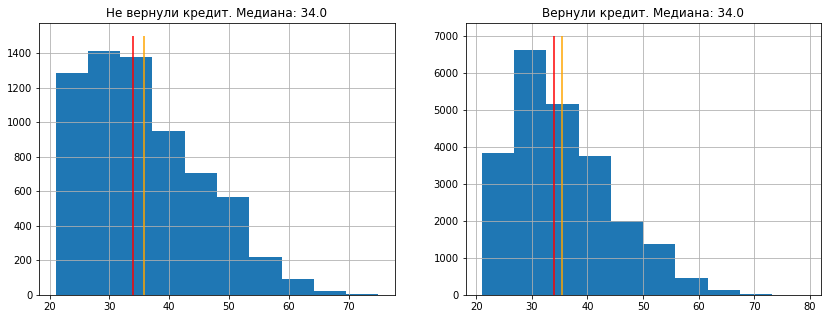

In [37]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
age_nr.hist()
plt.vlines(age_nr.median(), ymin=0, ymax=1500, color='r')
plt.vlines(age_nr.mean(), ymin=0, ymax=1500, color='orange')
plt.title('Не вернули кредит. Медиана: {}'.format(age_nr.median()))
plt.subplot(1, 2, 2)
age_r.hist()
plt.vlines(age_r.median(), ymin=0, ymax=7000, color='r')
plt.vlines(age_r.mean(), ymin=0, ymax=7000, color='orange')
_ = plt.title('Вернули кредит. Медиана: {}'.format(age_r.median()))

In [15]:
median_scores_age_nr = list(map(np.median, get_bootstrap_samples(age_nr.values, 10000)))
median_scores_age_r = list(map(np.median, get_bootstrap_samples(age_r.values, 10000)))

print("95% confidence interval for NOT returned a loan:",  stat_intervals(median_scores_age_nr))
print("95% confidence interval for for returned a loan:",  stat_intervals(median_scores_age_r))

95% confidence interval for NOT returned a loan: [34. 34.]
95% confidence interval for for returned a loan: [34. 34.]


In [33]:
median_scores_age_nr = list(map(np.mean, get_bootstrap_samples(age_nr.values, 10000)))
median_scores_age_r = list(map(np.mean, get_bootstrap_samples(age_r.values, 10000)))

print("95% confidence interval for NOT returned a loan:",  stat_intervals(median_scores_age_nr))
print("95% confidence interval for for returned a loan:",  stat_intervals(median_scores_age_r))

95% confidence interval for NOT returned a loan: [35.64598403 35.80831826]
95% confidence interval for for returned a loan: [35.37604862 35.45707071]


### (b) Ранговый критерий Манна-Уитни
$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [60]:
stats.mannwhitneyu(median_scores_age_nr, median_scores_age_r)

MannwhitneyuResult(statistic=986197.0, pvalue=0.0)

#### Выводы:<br>

Учитывая доверительный интервал и p-value можно уверенно отвергнуть гипотезу что возраст не влияет на возврат кредита